In [1]:
import numpy as np
import gurobipy as gp
import pandas as pd
import matplotlib.pyplot as plt

# Data Wrangling

In [2]:
df_train = pd.read_csv('training_data.csv')
df_test = pd.read_csv('test_data.csv')

df_train.head()

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,8.536145,-1.535413,0.718888,-2.099149,-0.442842,-0.598978,-1.642574,0.207755,0.760642,0.575874,...,0.361866,1.793098,-0.631287,-0.061751,0.511049,0.488754,-0.612772,-0.471045,-1.139781,-0.260773
1,4.808344,-1.734609,0.551981,-2.147673,-1.552944,1.514910,-1.143972,0.737594,1.321243,-0.261684,...,-0.677985,-0.165679,0.065405,0.137162,1.258197,-0.120834,-1.564834,-0.242565,-0.001827,1.187453
2,-1.530427,0.097257,0.107634,-0.194222,0.335454,-0.408199,0.133265,0.706179,0.394971,-0.437116,...,1.108801,0.333791,0.282055,-1.086294,-0.115354,0.257857,-0.088838,-0.751231,1.450609,0.290593
3,-0.428243,-0.067702,0.557836,0.700848,-1.121376,1.722274,0.613525,0.700909,-0.417976,1.069749,...,0.692511,-0.350990,0.624558,0.434520,-0.367409,-1.144681,-0.136524,-0.557214,0.416303,0.484495
4,0.566694,0.488729,0.211483,0.568389,0.646837,0.163868,-0.002152,0.125137,0.493571,1.705451,...,-0.000605,1.075280,0.182281,-1.138458,0.106092,0.544640,-0.383487,-0.425773,2.667647,-0.050748


In [3]:
X_train = df_train.drop(['y'], axis=1)
y_train = df_train['y']

X_test = df_test.drop(['y'], axis=1)
y_test = df_test['y']

# Indirect Variable Selection – LASSO

#### Create the LASSO model and find the best lamda

In [4]:
# Import LassoCV model from sklearn
from sklearn.linear_model import LassoCV

# 10 fold cross validation
LassoCross = LassoCV(cv=10, random_state=0)
LassoCross.fit(X_train, y_train)

# Find the best lambda after cross validation
best_lambda = LassoCross.alpha_
print('The best lambda:', LassoCross.alpha_)

The best lambda: 0.07638765995113507


#### Create the LASSO model using the best lambda and evaluate the model

In [5]:
# Fit a LASSO model with the best lambda
from sklearn.linear_model import Lasso
LassoModel = Lasso(alpha=best_lambda)
LassoModel.fit(X_train, y_train)

# Predict the y-values of the test data
y_pred_LASSO = LassoModel.predict(X_test)
y_pred_LASSO

array([ 6.07686351,  4.9181073 ,  3.22777954,  3.57138566, -0.41849943,
       -4.94878307, -2.8218873 , -1.49522305,  1.38296395, -0.24746403,
       -1.94701631,  2.70749465,  0.64484559, -0.50918617, -0.31915912,
        7.37584986, -7.54781954,  3.59673093, -4.39624331, -2.98890566,
       -1.94423698,  3.33248953, -2.42122798,  1.13315219, -2.53307168,
       -0.15595162, -1.62271875, -2.31420693, -3.46402012, -3.71707635,
       -1.66827581, -0.07491137,  1.40363987,  5.45269115, -1.20270399,
        2.37325349,  4.74719816,  3.13015173,  1.55100085,  5.85587702,
       -0.81232674,  4.66231732, -5.71548761, -1.20927664,  4.25279319,
        4.09734242,  3.8335482 ,  0.61787077,  1.89407804, -1.02592954])

In [6]:
# Evaluate the model
from sklearn.metrics import mean_squared_error
mse_LASSO = mean_squared_error(y_test, y_pred_LASSO)
print('The MSE of the LASSO model on the test data is:', mse_LASSO)

The MSE of the LASSO model on the test data is: 2.3496347591605797


# Direct Variable Selection – MIQP Problem

Methodology:
* Formulate the Gurboi model 
* Find the best k (number of betas), where we minimize the sum of squared errors (in the validation set of the 10-fold cross-validation)
* Fit the entire training data using our Gurobi model with the best k and predict the y-values of the test data

#### Creating the MIQP model

In [7]:
# We use numpy arrays instead of pandas dataframes for the Gurobi model
y_train = df_train['y'].values
X_train = df_train.drop(['y'], axis=1).values

In [8]:
# number of betas we start with
# 50 because we have 50 X variables
num_betas = 50
# from our LASSO model above we can safely say 
# a big M of 80 is big enough since all coefficients are single digits
M = 80

def opt_model(X_train,y_train, k):
    '''
    MIQP model that returns the optimal intercept and betas with k betas selected
    '''

    # add a column of 1s to X_train, so that we can include the intercept in the model
    # the 2*num_betas+1 later is because we have 2*num_betas+1 variables in total (num_betas betas, num_betas z's, and 1 intercept)
    X = np.insert(X_train, 0, [1] * len(X_train), axis=1)
    

    # Q, quadratic matrix, 2*num_betas+1 rows, 2*num_betas+1 columns 
    Q_matrix = np.zeros((2*num_betas+1, 2*num_betas+1))
    # first num_betas+1 rows and columns are for the quadratic term, the rest are zeros
    Q_matrix[0:num_betas+1, 0:num_betas+1] = np.transpose(X) @ X
    # print('Q Matrix \n', Q_matrix)

    # c, linear vector, 2*num_betas+1 rows, 1 column
    c_vector = np.zeros((2*num_betas+1, 1))
    # first num_betas+1 rows are for the linear term, the rest are zeros
    c_vector[0:num_betas+1, 0] = -2 * np.transpose(y_train) @ X
    # convert c_vector to 1D array for gurobi's setMObjective function
    c_vector_1D = np.array([])
    for i in range(2*num_betas+1):
        c_vector_1D = np.append(c_vector_1D, c_vector[i][0])
    # print('c vector \n', c_vector_1D)


    # lb, lower boundary vector
    # intercept has no lower boundary, beta has lower boundary of -M, and z has no lower boundary
    lb_1 = np.array([-np.inf] + [-M]*num_betas)
    lb_2 = [-np.inf]*num_betas
    Model = gp.Model()
    # intercept and betas are continuous, z is binary
    Model_int_betas = Model.addMVar(num_betas+1,lb=lb_1,vtype=['C'])
    Model_z = Model.addMVar(num_betas,lb = lb_2,vtype=['B'])

    # limit the total number betas to be less than k
    k_cons = Model.addConstr(sum(Model_z) <= k)
    # adding several big M constraints, so is addConstrs
    bigMcons_pos = Model.addConstrs((Model_int_betas[i+1] <= M*Model_z[i]) for i in range(num_betas))
    bigMcons_neg = Model.addConstrs((Model_int_betas[i+1] >= -M*Model_z[i]) for i in range(num_betas))

    # the first argument of setMObjective() is the quadratic matrix, the second is the linear vector (need 1D), the third is the constant
    Model.setMObjective(Q_matrix,c_vector_1D,0,sense=gp.GRB.MINIMIZE)
    
    Model.Params.TimeLimit = 30 # set time limit of 30 seconds
    Model.Params.OutputFlag = 0 # tell gurobi to shut up!!
    Model.optimize()

    # return the intercept and the betas
    return np.array(Model.x[0:num_betas+1])

#### Finding the best k when using 10-fold cross validation

In [9]:
import random

def cross_validation_split(df_train, num_folds):
    """
    Shuffles the data and splits it into 'num_folds' sections for cross-validation.
    Returns a list of tuples, where each tuple contains a training set and a validation set.
    """

    # Convert the DataFrame to a list of lists
    df_train_values = df_train.values.tolist()
    # Shuffle the data randomly
    random.shuffle(df_train_values)

    # Determine the size of each section
    data_size = len(df_train_values) // num_folds

    # Split the data into 'num_folds' sections
    data_sections= []
    for i in range(num_folds):
        # Determine the starting and ending indices for the validation set
        start_idx = i * data_size
        end_idx = start_idx + data_size

        # Create the training and validation sets
        training_set = df_train_values[:start_idx] + df_train_values[end_idx:]
        validation_set = df_train_values[start_idx:end_idx]

        # Add the current data sections to the list of data sections
        data_sections.append((training_set, validation_set))
    return data_sections

In [10]:
def cross_validation(df_train, num_folds, k_list):
    """
    Performs 'num_folds' folds of cross-validation on the given data.
    Returns the average MSE of the models trained on each fold.
    """

    best_k = {}
    for k in k_list:
        # Split the data into 'num_folds' folds
        data_sections = cross_validation_split(df_train, num_folds)

        # Model is trained on 10-1 of the folds and validated on the remaining fold. 
        # This process is repeated 10 times, with each of the 10 folds used once as the validation set
        mse_list = []
        for training_set, validation_set in data_sections:
            # Convert the training and validation sets to NumPy arrays
            training_set = np.array(training_set)
            validation_set = np.array(validation_set)

            # Separate the features and labels for the training and validation sets
            X_train = training_set[:, 1:]
            y_train = training_set[:, 0]
            X_val = validation_set[:, 1:]
            y_val = validation_set[:, 0]

            # Train a model on the training set
            int_betas = opt_model(X_train, y_train, k)

            # Compute the MSE on the validation set
            mse = mean_squared_error(y_val, int_betas[0]+X_val@int_betas[1:])
            mse_list.append(mse)
        # Compute the average MSE of the models trained on each of the 10-1 folds
        best_k[k] = np.mean(mse_list)

    # Sort the average MSEs in ascending order
    best_k = sorted(best_k.items(), key=lambda x: x[1])
    return best_k


k_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
k_dictionary = cross_validation(df_train, 10, k_list)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-23
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set param

In [11]:
# Print the average MSE of the models trained on each of the 10-1 folds
print(k_dictionary)

[(10, 3.0456084332778675), (25, 3.057191978434262), (15, 3.1156383343939855), (20, 3.1325301638031795), (45, 3.3337875637471344), (40, 3.3370889711533316), (30, 3.343760389414432), (50, 3.3721651396781622), (35, 3.5461706515898115), (5, 3.787711744337506)]


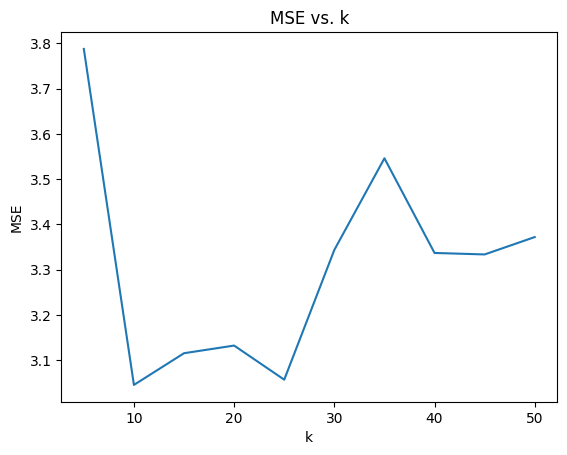

In [12]:
# Graph the MSEs for each value of k
k_dictionary_graph = sorted(k_dictionary, key=lambda x: x[0])
plt.plot([k for k, mse in k_dictionary_graph], [mse for k, mse in k_dictionary_graph])
plt.xlabel('k')
plt.ylabel('MSE')
plt.title('MSE vs. k')
plt.show()

#### Model evaluation on out of sample (testing set) data

In [13]:
# Train on the entire training set using the best k
int_betas = opt_model(X_train, y_train, k_dictionary[0][0])

# Predict the y-values for the test set
y_pred_MIQP = int_betas[0]+X_test@int_betas[1:]
y_pred_MIQP

Set parameter TimeLimit to value 30


0     6.179859
1     5.095243
2     3.285595
3     3.758485
4    -0.332975
5    -5.142737
6    -3.144544
7    -1.238063
8     1.385111
9    -0.441739
10   -1.695002
11    2.730350
12    0.747449
13   -0.971922
14   -0.686815
15    8.045224
16   -7.946985
17    3.890640
18   -4.581429
19   -3.219921
20   -2.162115
21    3.216863
22   -3.198105
23    0.197407
24   -2.359888
25   -0.419999
26   -1.912522
27   -3.324186
28   -3.141710
29   -3.553793
30   -1.808425
31   -0.371343
32    1.867081
33    5.049279
34   -1.800056
35    3.094277
36    4.381543
37    2.698863
38    1.613289
39    5.975846
40   -1.197358
41    5.223254
42   -5.848999
43   -1.144615
44    4.518030
45    4.187749
46    4.120460
47    0.614838
48    1.957232
49   -1.549044
dtype: float64

In [14]:
# Compute the MSE on the test set
mse_MIQP = mean_squared_error(y_test, int_betas[0]+X_test@int_betas[1:])
print('The MSE on the test set is', mse_MIQP)

The MSE on the test set is 2.336543964552525


# Conclusion

From our models, we can see that direct variable selection is slightly better than indirect variable selection, with lower MSE on the test data (2.35 versus 2.34).

The graphs below show how both methods have similar performances, with only marginal differences.

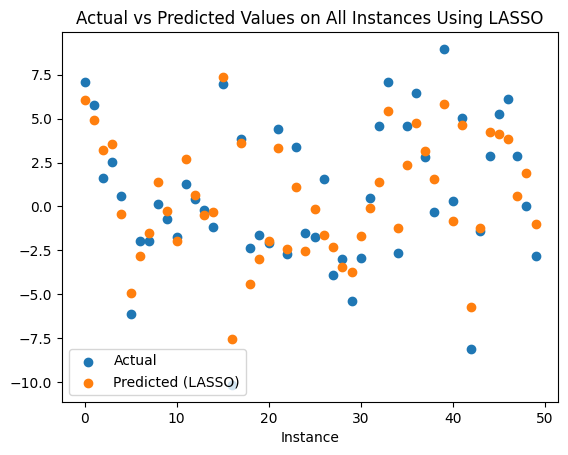

In [15]:
# Graph showing the given vs predicted values on X1 for LASSO
fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(df_test.index.values, y_test, label = 'Actual')
ax.scatter(df_test.index.values, y_pred_LASSO, label = 'Predicted (LASSO)')
plt.legend()
plt.xlabel('Instance')
plt.title('Actual vs Predicted Values on All Instances Using LASSO')
plt.show()

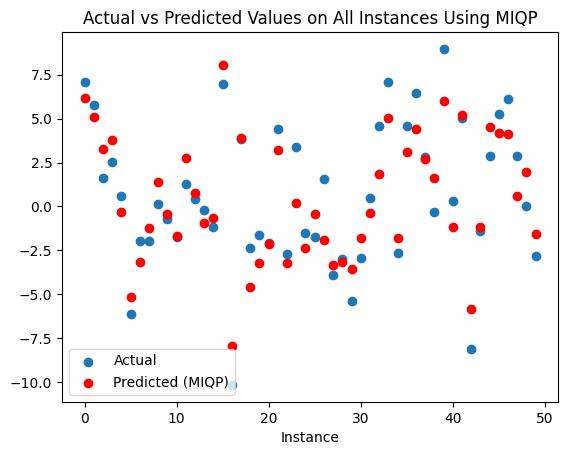

In [16]:
# Graph showing the given vs predicted values on X1 for MIQP
fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(df_test.index.values, y_test, label = 'Actual')
ax.scatter(df_test.index.values, y_pred_MIQP, c = 'r', label = 'Predicted (MIQP)')

plt.legend()
plt.xlabel('Instance')
plt.title('Actual vs Predicted Values on All Instances Using MIQP')
plt.show()

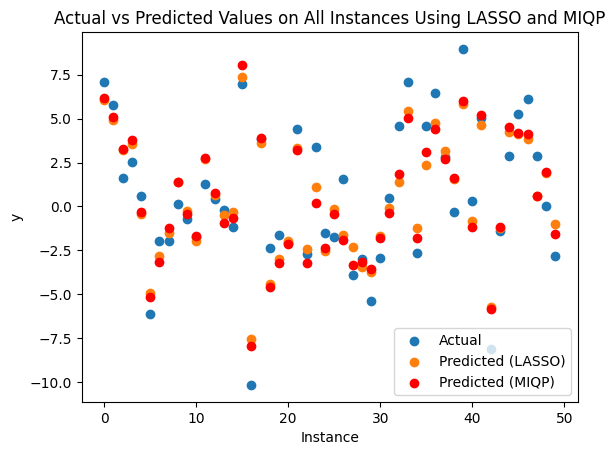

In [17]:
# Graph showing the given vs predicted values on X1 for LASSO and MIQP
fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(df_test.index.values,y_test, label = 'Actual')
ax.scatter(df_test.index.values,y_pred_LASSO, label = 'Predicted (LASSO)')
ax.scatter(df_test.index.values,y_pred_MIQP, c='r', label = 'Predicted (MIQP)')
plt.legend()
plt.xlabel('Instance')
plt.ylabel('y')
plt.title('Actual vs Predicted Values on All Instances Using LASSO and MIQP')
plt.show()

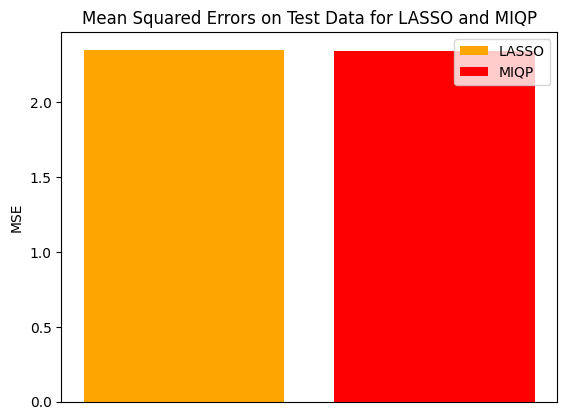

In [18]:
# Graph showing the MSEs for LASSO and MIQP
fig, ax = plt.subplots()

ax.bar(0,mse_LASSO, color='orange', label='LASSO')
ax.bar(1,mse_MIQP, color='red',label='MIQP')

ax.axes.get_xaxis().set_visible(False)

plt.legend()
plt.ylabel('MSE')
plt.title('Mean Squared Errors on Test Data for LASSO and MIQP')
plt.show()